In [2]:
import pandas as pd 

test = pd.read_csv("Test.csv")
train = pd.read_csv("Train.csv")

In [14]:
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm

def convert_png_to_jpg(input_csv, output_folder1, output_folder2):
    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv(input_csv)
    
    # df = df[df['ClassId'] == 0]
    # df = df.head(5)

    # Create the output folders if they don't exist
    os.makedirs(output_folder1, exist_ok=True)
    os.makedirs(output_folder2, exist_ok=True)

    # Use tqdm to track the progress
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Converting and generating labels"):
        image_path = row['Path']
        class_id = row['ClassId']
        x1, y1, x2, y2 = [float(j) for j in [row['x1'], row['y1'], row['x2'], row['y2']]]

        # Read the PNG image using PIL
        png_image = Image.open(image_path)

        # Convert PNG image to JPG
        jpg_image_path = os.path.join(output_folder1, f"{class_id}_{index}.jpg")
        png_image.save(jpg_image_path, "JPEG")

        # Generate label file for the image
        label_file_path = os.path.join(output_folder2, f"{class_id}_{index}.txt")
        with open(label_file_path, 'w') as f_ann:
            img_width, img_height = png_image.size
            xc = (x1 + x2) / 2 / img_width
            yc = (y1 + y2) / 2 / img_height
            w = (x2 - x1) / img_width
            h = (y2 - y1) / img_height

            f_ann.write('{} {} {} {} {}'.format(class_id, xc, yc, w, h))

    print("Conversion and label generation completed!")


In [2]:
# The following code converts the original image to YOLOv8 format dataset 

input_csv_file = "train.csv"
output_folder_path1 = "data/train/images/"
output_folder_path2 = "data/train/labels/"
convert_png_to_jpg(input_csv_file, output_folder_path1,output_folder_path2)

input_csv_file = "test.csv"
output_folder_path1 = "data/test/images/"
output_folder_path2 = "data/test/labels/"
convert_png_to_jpg(input_csv_file, output_folder_path1,output_folder_path2)


## Preprocess the data so that each Image is having 4-5 signals . Converting it to yolo format after it is merged

In [26]:

import os
import pandas as pd
from PIL import Image, ImageDraw
import random

# Function to merge images with bounding boxes
def merge_images_with_bboxes(image_paths, bboxes_list, output_folder):
    merged_width = 0
    merged_height = 0
    for path in image_paths:
        img = Image.open(path)
        merged_width += img.width
        merged_height = max(merged_height, img.height)
        img.close()

    spacing = 10  # Adjust the spacing between images

    merged_image = Image.new("RGB", (merged_width + spacing * (len(image_paths) - 1), merged_height), (255, 255, 255))

    x_offset = 0
    annotations = []

    for i, (path, bboxes) in enumerate(zip(image_paths, bboxes_list)):
        img = Image.open(path)
        merged_image.paste(img, (x_offset, 0))
        img.close()

        x1, y1, x2, y2, class_id = bboxes
        x1 += x_offset
        x2 += x_offset
        annotations.append([x1, y1, x2, y2, class_id, os.path.basename(path)])

        x_offset += img.width + spacing

    merged_image_path = os.path.join(output_folder, "merged_image.png")
    merged_image.save(merged_image_path)
    return merged_image_path, annotations

# Read the CSV file
csv_file = "Train.csv"
output_folder = "output_folder"
os.makedirs(output_folder, exist_ok=True)

df = pd.read_csv(csv_file)

# Merge randomly selected 3-4 images
num_images_to_merge = random.randint(3,6)  # Randomly choose between 3 and 4 images to merge
merged_images_info = []
num_rows = len(df)

while num_rows > 0:
    selected_indices = random.sample(range(num_rows), num_images_to_merge)
    selected_rows = df.iloc[selected_indices]
    image_paths = selected_rows["Path"].tolist()
    bboxes_list = [row[["Roi.X1", "Roi.Y1", "Roi.X2", "Roi.Y2", "ClassId"]].values.tolist() for _, row in selected_rows.iterrows()]

    merged_image_path, updated_annotations = merge_images_with_bboxes(image_paths, bboxes_list, output_folder)
    merged_images_info.append((merged_image_path, updated_annotations))

    # Remove the selected rows from the DataFrame to avoid selecting them again
    df = df.drop(selected_indices).reset_index(drop=True)
    num_rows = len(df)

# Create a new CSV file with updated annotations
merged_csv_file = "merged_annotations.csv"
merged_df = pd.DataFrame(columns=["x1", "y1", "x2", "y2", "ClassId", "Path"])

for idx, (image_path, annotations) in enumerate(merged_images_info):
    for annotation in annotations:
        merged_df = merged_df.append(
            {"x1": annotation[0], "y1": annotation[1], "x2": annotation[2], "y2": annotation[3], "ClassId": annotation[4], "Path": f"merged_{idx}.png"},
            ignore_index=True
        )

merged_df.to_csv(merged_csv_file, index=False)

print(f"Merged images and updated CSV file saved in {output_folder} and {merged_csv_file}, respectively.")

Image: output_folder_Test\merged_imageFJ0KIC.png
Bounding Box 1: (x1=18, y1=16, x2=192, y2=171)
Bounding Box 2: (x1=225, y1=6, x2=258, y2=42)
Bounding Box 3: (x1=279, y1=6, x2=301, y2=32)


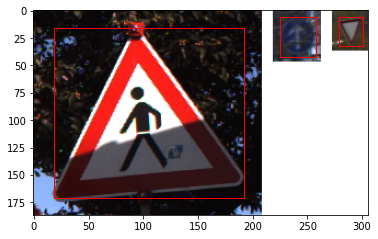

Image: output_folder_Test\merged_image68JS94.png
Bounding Box 1: (x1=5, y1=6, x2=29, y2=34)
Bounding Box 2: (x1=50, y1=5, x2=69, y2=22)
Bounding Box 3: (x1=91, y1=5, x2=120, y2=46)
Bounding Box 4: (x1=145, y1=8, x2=220, y2=84)
Bounding Box 5: (x1=245, y1=6, x2=301, y2=61)


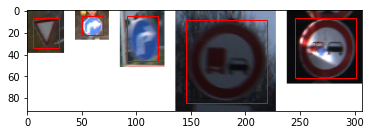

Image: output_folder_Test\merged_image0Y5KEH.png
Bounding Box 1: (x1=6, y1=6, x2=30, y2=30)
Bounding Box 2: (x1=54, y1=9, x2=138, y2=98)
Bounding Box 3: (x1=163, y1=6, x2=193, y2=37)
Bounding Box 4: (x1=219, y1=12, x2=326, y2=118)


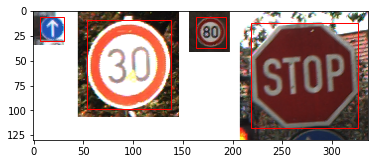

Image: output_folder_Test\merged_imageY95CB6.png
Bounding Box 1: (x1=5, y1=5, x2=37, y2=34)
Bounding Box 2: (x1=58, y1=6, x2=84, y2=39)
Bounding Box 3: (x1=104, y1=6, x2=126, y2=29)
Bounding Box 4: (x1=147, y1=6, x2=171, y2=32)
Bounding Box 5: (x1=192, y1=5, x2=207, y2=24)


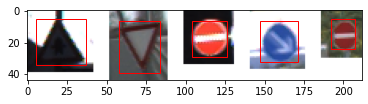

Image: output_folder_Test\merged_imageNK42H3.png
Bounding Box 1: (x1=5, y1=6, x2=50, y2=50)
Bounding Box 2: (x1=71, y1=6, x2=123, y2=51)
Bounding Box 3: (x1=143, y1=5, x2=166, y2=29)
Bounding Box 4: (x1=186, y1=6, x2=214, y2=33)
Bounding Box 5: (x1=240, y1=11, x2=336, y2=106)
Bounding Box 6: (x1=361, y1=5, x2=400, y2=42)


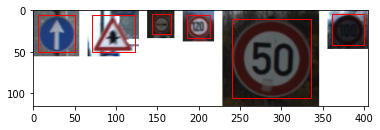

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the CSV file into a DataFrame
csv_file_path = 'merged_annotations_test.csv'
df = pd.read_csv(csv_file_path)

# Get unique image paths
unique_image_paths = df['Path'].unique()

# Function to plot image with bounding boxes
def plot_image_with_boxes(image_path, boxes):
    # Load the image
    image = plt.imread(image_path)

    # Create figure and axes
    fig, ax = plt.subplots()
    ax.imshow(image)

    # Plot bounding boxes
    for box in boxes:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Function to get bounding boxes for a given image path
def get_bounding_boxes_for_image(image_path):
    boxes = df[df['Path'] == image_path][['x1', 'y1', 'x2', 'y2']].values
    return boxes

# Get 5 images and their bounding boxes
for image_path in unique_image_paths[:5]:
    boxes = get_bounding_boxes_for_image(image_path)
    print("Image:", image_path)
    for i, box in enumerate(boxes):
        print(f"Bounding Box {i+1}: (x1={box[0]}, y1={box[1]}, x2={box[2]}, y2={box[3]})")
    plot_image_with_boxes(image_path, boxes)
